In [5]:
# Imports
# External imports
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Module imports
import biological_fuzzy_logic_networks.biofuzznet as biofuzznet
import biological_fuzzy_logic_networks.biofuzzdataset as biofuzzdataset
import biological_fuzzy_logic_networks.Hill_function as Hill_function
import biological_fuzzy_logic_networks.utils as utils
import biological_fuzzy_logic_networks.draw as draw
import biological_fuzzy_logic_networks.biomixnet as biomixnet

In [3]:
# Create an empty BioFuzzNet
G_not = biofuzznet.BioFuzzNet(None, None)

# Add nodes
G_not.add_fuzzy_node("A", "BIO") # A biological node
G_not.add_fuzzy_node("B", 'BIO') # B biological node
G_not.add_fuzzy_node("C", 'BIO') # C biological node
G_not.add_fuzzy_node("D", 'BIO') # D biological node
G_not.add_fuzzy_node("A AND B", "AND") # A logical and gate

# Add edges
G_not.add_transfer_edge("A", "A AND B") # A transfer edge downstream of a biological node
G_not.add_transfer_edge("B", "A AND B") # A transfer edge downstream of a biological node
G_not.add_simple_edge("A AND B", "C") # A simple edge downstream of a logical node
G_not.add_transfer_edge("C", "D") # A transfer edge downstream of a biological node

{'B': array([-0.55555556, -1.33333333]),
 'A': array([ 0.55555556, -1.33333333]),
 'A AND B': array([ 0.        , -0.22222222]),
 'C': array([0.        , 0.88888889]),
 'D': array([0., 2.])}

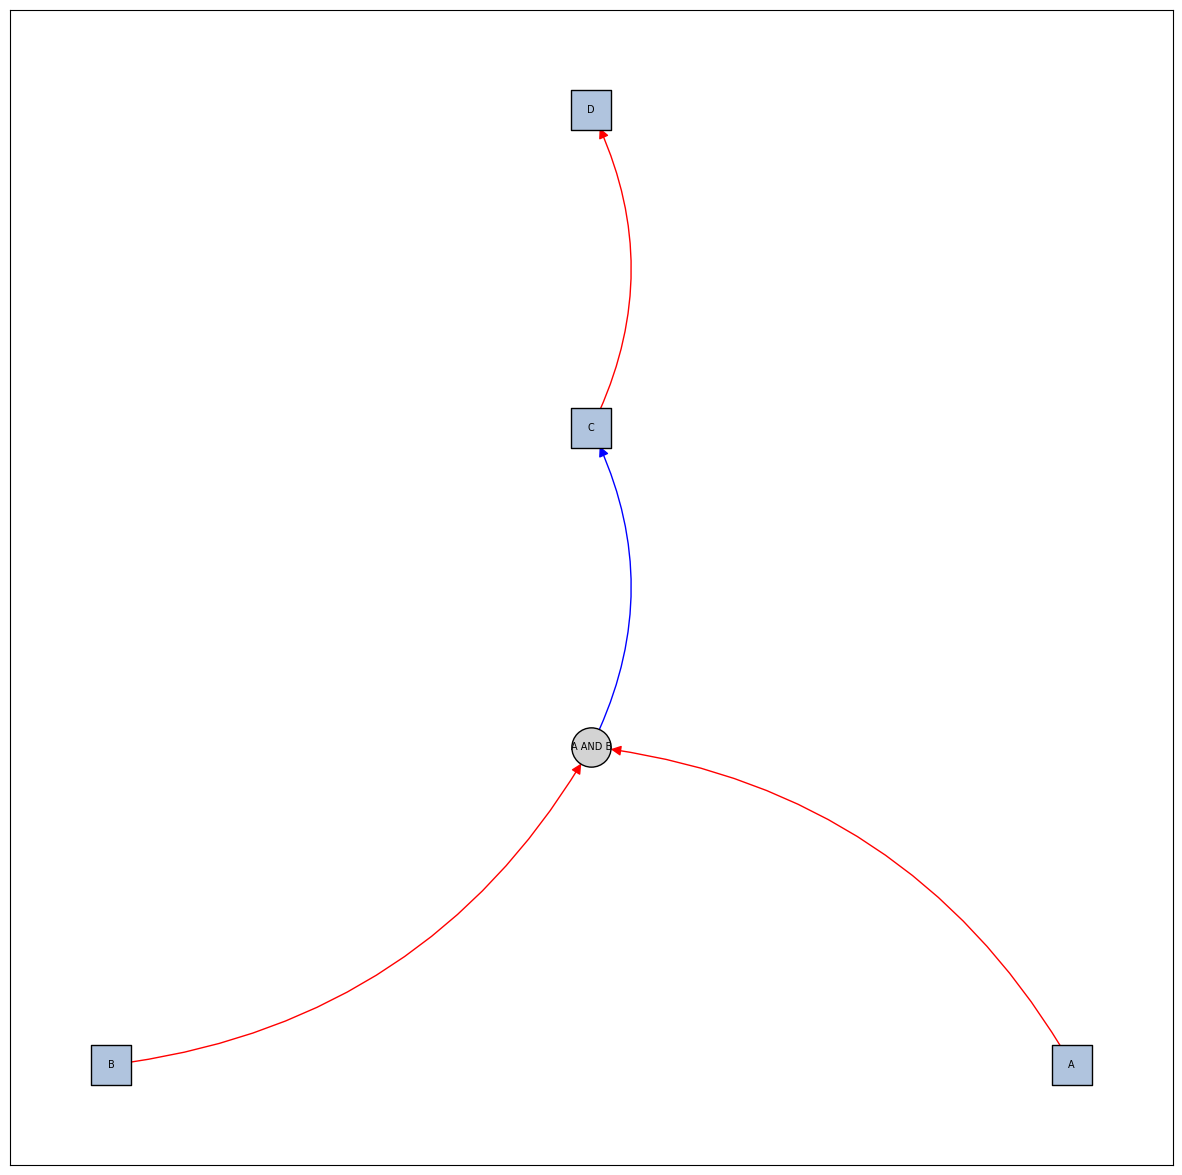

In [8]:
# Draw the networks to compare them
# Color schemes for the drawing
general_edge_color_scheme  = {"simple": "b", "transfer_function": "r"}
general_node_shape_scheme = {"biological": 's', "logic_gate_AND": 'o', "logic_gate_OR": 'd', "logic_gate_NOT": '^'}

draw.draw_BioFuzzNet(G_not, general_edge_color_scheme, general_node_shape_scheme)  

In [9]:
G_not.transfer_edges

[('A', 'A AND B'), ('B', 'A AND B'), ('C', 'D')]

In [10]:
for edge in G_not.transfer_edges:
    # Each transfer edge has a layer
    layer = G_not.edges()[edge]["layer"]
    # Each layer has a n and an K parameter
    print(f"The edge {edge} has parameter n = {torch.exp(layer.n)} and K = {torch.sigmoid(layer.K)}")
    # Those parameters are torch.nn.Parameters and thus have a grad_fn which corresponds to their gradient

The edge ('A', 'A AND B') has parameter n = tensor([2.2338], grad_fn=<ExpBackward0>) and K = tensor([0.4914], grad_fn=<SigmoidBackward0>)
The edge ('B', 'A AND B') has parameter n = tensor([0.2109], grad_fn=<ExpBackward0>) and K = tensor([0.3160], grad_fn=<SigmoidBackward0>)
The edge ('C', 'D') has parameter n = tensor([0.6405], grad_fn=<ExpBackward0>) and K = tensor([0.4504], grad_fn=<SigmoidBackward0>)


In [11]:
G_not.root_nodes

['A', 'B']

In [12]:
# print(f"The current output state at node 41BB is {my_model.nodes()['41BB']['output_state']} and the current ground truth is {my_model.nodes()['41BB']['ground_truth']}")
print(G_not.nodes()["A"]["output_state"])
print(G_not.nodes()["A"]["ground_truth"])

None
None


In [13]:
G_not.set_network_ground_truth({"A": torch.tensor(1), "B": torch.tensor(1), "D": torch.tensor(1)})


/Users/adr/Projects/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/biofuzznet.py:366: UserWarning: Node C is not present in ground truth. Its ground_truth value is not set.
  warnings.warn(


In [14]:

G_not.sequential_update(["A", "B", "D"])

In [15]:
G_not.output_states

{'A': tensor(1),
 'B': tensor(1),
 'C': tensor([0.2807], grad_fn=<MulBackward0>),
 'D': tensor([0.3348], grad_fn=<DivBackward0>)}

In [16]:
G_not.nodes()["A"]["ground_truth"]

tensor(1)

# Simulation and Optimization

In [17]:
ground_truth_dict = {"A": torch.ones(3000), "B": torch.ones(3000), "C":torch.ones(3000)}
G_not.set_network_ground_truth(ground_truth=ground_truth_dict)

/Users/adr/Projects/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/biofuzznet.py:366: UserWarning: Node D is not present in ground truth. Its ground_truth value is not set.
  warnings.warn(


In [18]:
G_not.sequential_update(["A", "B", "C"])

In [19]:
ground_truth_to_find = G_not.output_states

# Let's define the inputs and ground_truth for the training and validation set
ground_truth_train = {node: ground_truth_to_find[node][0:2000] for node in ground_truth_to_find.keys()}
ground_truth_test = {node: ground_truth_to_find[node][2000:3000] for node in ground_truth_to_find.keys()}

# The input is just the ground truth values at the root nodes
input_train = {node: ground_truth_train[node] for node in ["A", "B", "C"]}
input_test = {node: ground_truth_test[node] for node in ["A", "B", "C"]}

In [20]:
# Then we create a model to optimise: same topology, but different parameters at the transfer function
# Create an empty BioFuzzNet
G_optim = biofuzznet.BioFuzzNet(None, None)

# Add nodes
G_optim.add_fuzzy_node("A", "BIO") # A biological node
G_optim.add_fuzzy_node("B", 'BIO') # B biological node
G_optim.add_fuzzy_node("C", 'BIO') # C biological node
G_optim.add_fuzzy_node("D", 'BIO') # D biological node
G_optim.add_fuzzy_node("A AND B", "AND") # A logical not gate

# Add edges
G_optim.add_transfer_edge("A", "A AND B") # A transfer edge downstream of a biological node
G_optim.add_transfer_edge("B", "A AND B") # A transfer edge downstream of a biological node
G_optim.add_simple_edge("A AND B", "C") # A simple edge downstream of a logical node
G_optim.add_transfer_edge("C", "D") # A transfer edge downstream of a biological node

In [21]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 10 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 



In [22]:
# Now let's optimise

loss = G_optim.conduct_optimisation(input = input_train,
                                         ground_truth=ground_truth_train,
                                         test_input = input_test,
                                         test_ground_truth= ground_truth_test,
                                         epochs = epochs, 
                                         learning_rate= learning_rate,
                                         batch_size= batch_size
                                         )

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


In [23]:
G_optim.output_states

{'A': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.

In [24]:
for edge in G_optim.transfer_edges:
    # Each transfer edge has a layer
    layer = G_optim.edges()[edge]["layer"]
    # Each layer has a n and an K parameter
    print(f"The edge {edge} has parameter n = {torch.exp(layer.n)} and K = {torch.sigmoid(layer.K)}")
    # Those parameters are torch.nn.Parameters and thus have a grad_fn which corresponds to their gradient

The edge ('A', 'A AND B') has parameter n = tensor([1.5065], grad_fn=<ExpBackward0>) and K = tensor([0.6817], grad_fn=<SigmoidBackward0>)
The edge ('B', 'A AND B') has parameter n = tensor([1.6778], grad_fn=<ExpBackward0>) and K = tensor([0.0992], grad_fn=<SigmoidBackward0>)
The edge ('C', 'D') has parameter n = tensor([0.5853], grad_fn=<ExpBackward0>) and K = tensor([0.3145], grad_fn=<SigmoidBackward0>)


In [25]:
for edge in G_optim.transfer_edges:
    # Each transfer edge has a layer
    layer = G_optim.edges()[edge]["layer"]
    # Each layer has a n and an K parameter
    print(f"The edge {edge} has parameter n = {torch.exp(layer.n)} and K = {torch.sigmoid(layer.K)}")
    # Those parameters are torch.nn.Parameters and thus have a grad_fn which corresponds to their gradient

The edge ('A', 'A AND B') has parameter n = tensor([1.5065], grad_fn=<ExpBackward0>) and K = tensor([0.6817], grad_fn=<SigmoidBackward0>)
The edge ('B', 'A AND B') has parameter n = tensor([1.6778], grad_fn=<ExpBackward0>) and K = tensor([0.0992], grad_fn=<SigmoidBackward0>)
The edge ('C', 'D') has parameter n = tensor([0.5853], grad_fn=<ExpBackward0>) and K = tensor([0.3145], grad_fn=<SigmoidBackward0>)
